## Import Library

In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt
import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

In [162]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Data Loading & Cleaning

In [163]:
df = pd.read_csv('all_film_reviews.csv')

df.head()

,film,username,review,rating
0,Dune (2021),Jay,how you gonna birth the chosen one with unlimi...,★★★½
1,Dune (2021),Karsten,got the 4D experience by forgetting to drink w...,★★★★½
2,Dune (2021),cookie,not bad if u ever just feel like staring at th...,★★½
3,Dune (2021),molly,I relate to paul because i also have recurring...,★★★★
4,Dune (2021),Julien Debaker,I'm sorry but I can't take Timothée Chalamet s...,★★★½


In [164]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30720 entries, 0 to 30719
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   film      30720 non-null  object
 1   username  30720 non-null  object
 2   review    30719 non-null  object
 3   rating    30720 non-null  object
dtypes: object(4)
memory usage: 960.1+ KB


In [165]:
df.describe(include='all')

,film,username,review,rating
count,30720,30720,30719,30720
unique,10,12353,30647,11
top,Dune (2021),Jake,Masterpiece,★★★★★
freq,3072,61,6,9322


In [166]:
df.isna().sum()

,0
film,0
username,0
review,1
rating,0


In [167]:
df = df.dropna(subset=['review'])

In [168]:
df.duplicated().sum()

np.int64(1)

In [169]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

<ipython-input-169-da2a6d66ab19>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(inplace=True)


np.int64(0)

In [170]:
# Rating bintang menjadi rating numerik
def convert_rating(rating_str):
    if rating_str == 'No rating':
        return np.nan
    score = 0
    score += rating_str.count('★') * 2
    if '½' in rating_str:
        score += 1
    return score

df['numeric_rating'] = df['rating'].apply(convert_rating)
df['numeric_rating'] = df['numeric_rating'].fillna(df['numeric_rating'].median())

<ipython-input-170-a8e6bf0e1d9c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['numeric_rating'] = df['rating'].apply(convert_rating)
<ipython-input-170-a8e6bf0e1d9c>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['numeric_rating'] = df['numeric_rating'].fillna(df['numeric_rating'].median())


In [171]:
df.describe()

,numeric_rating
count,30718.000000
mean,7.641871
std,2.333377
min,1.000000
25%,6.000000
50%,8.000000
75%,10.000000
max,10.000000


In [172]:
df.head()

,film,username,review,rating,numeric_rating
0,Dune (2021),Jay,how you gonna birth the chosen one with unlimi...,★★★½,7.0
1,Dune (2021),Karsten,got the 4D experience by forgetting to drink w...,★★★★½,9.0
2,Dune (2021),cookie,not bad if u ever just feel like staring at th...,★★½,5.0
3,Dune (2021),molly,I relate to paul because i also have recurring...,★★★★,8.0
4,Dune (2021),Julien Debaker,I'm sorry but I can't take Timothée Chalamet s...,★★★½,7.0


## Text Preprocessing

In [173]:
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

slangwords = {
    "u": "you", "ur": "your", "r": "are", "ya": "you", "im": "i am",
    "ive": "i have", "idk": "i don't know", "lol": "laughing out loud", "omg": "oh my god", "wtf": "what the fuck",
    "wth": "what the hell", "btw": "by the way", "brb": "be right back", "bbl": "be back later", "ttyl": "talk to you later",
    "bff": "best friend forever", "tbh": "to be honest", "ikr": "i know right", "lmao": "laughing my ass off", "rofl": "rolling on the floor laughing",
    "smh": "shaking my head", "fyi": "for your information", "omfg": "oh my freaking god", "bday": "birthday", "thx": "thanks",
    "ty": "thank you", "np": "no problem", "cuz": "because", "bc": "because", "tho": "though",
    "ya'll": "you all", "lemme": "let me", "gonna": "going to", "wanna": "want to", "gotta": "got to",
    "ain't": "is not", "dont": "do not", "cant": "cannot", "couldnt": "could not", "wouldnt": "would not",
    "shouldnt": "should not", "ain’t": "is not", "nah": "no", "yea": "yeah", "alr": "already",
    "idc": "i don't care", "nope": "no", "ok": "okay", "k": "okay", "bro": "brother",
    "sis": "sister", "luv": "love", "hbd": "happy birthday", "ttys": "talk to you soon", "gr8": "great",
    "2day": "today", "b4": "before", "l8r": "later", "2moro": "tomorrow", "sup": "what's up",
    "yo": "hello", "oml": "oh my lord", "hmu": "hit me up", "jk": "just kidding", "nvm": "never mind",
    "atm": "at the moment", "afk": "away from keyboard", "gg": "good game", "gl": "good luck", "hf": "have fun",
    "irl": "in real life", "rn": "right now", "tf": "the fuck", "tmi": "too much information", "wyd": "what are you doing",
    "bruh": "bro", "fr": "for real", "cap": "lie", "no cap": "no lie", "bet": "okay",
    "slay": "do well", "fire": "awesome", "lit": "exciting", "sus": "suspicious", "flex": "show off",
    "vibe": "atmosphere", "stan": "support", "simp": "overly obsessed", "salty": "bitter", "lowkey": "slightly",
    "highkey": "definitely", "dead": "laughing hard", "mood": "relatable feeling", "fam": "close friend", "goat": "greatest of all time",
    "yeet": "throw", "snatched": "stylish", "bussin": "delicious", "fax": "true", "based": "authentic",
    "ratio": "disagree", "bop": "good song", "cringe": "awkward", "dragged": "criticized", "w": "win",
    "l": "loss", "mid": "average", "pog": "amazing", "poggers": "awesome", "karen": "entitled woman",
    "boomer": "old person", "fomo": "fear of missing out", "jomo": "joy of missing out", "ftw": "for the win", "dm": "direct message",
    "clapback": "witty response", "ghosted": "ignored", "shade": "indirect insult", "cancelled": "boycotted", "drag": "criticize",
    "thirsty": "desperate", "spill": "reveal", "tea": "gossip", "hot take": "controversial opinion", "ok boomer": "dismissive phrase",
    "on fleek": "perfect", "woke": "socially aware", "hella": "very", "sksksk": "laughter", "and i oop": "surprise",
    "periodt": "end of discussion", "yass": "yes", "af": "as fuck", "tfw": "that feeling when", "idgaf": "i don't give a fuck",
    "tldr": "too long didn't read", "ily": "i love you", "ilysm": "i love you so much", "omw": "on my way", "wbu": "what about you",
    "gm": "good morning", "gn": "good night", "gtg": "got to go", "ily2": "i love you too", "bffl": "best friends for life"
}

In [174]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def cleaningText(text):
  text = re.sub(r'@[A-Za-z0-9]+', '', text) # remove mentions
  text = re.sub(r'#[A-Za-z0-9]+', '', text) # remove hashtag
  text = re.sub(r'RT[\s]', '', text) # remove RT
  text = re.sub(r"http\S+", '', text) # remove link
  text = re.sub(r'[0-9]+', '', text) # remove numbers
  text = re.sub(r'[^\w\s]', '', text) # remove numbers


  text = text.replace('\n', ' ') # replace new line into space
  text = text.translate(str.maketrans('', '', string.punctuation)) # remove all punctuations
  text = text.strip(' ') # remove characters space from both left and right text
  return text

def casefoldingText(text): # Converting all the characters in a text into lower case
  text = text.lower()
  return text

def tokenizingText(text): # Tokenizing or splitting a string, text into a list of tokens
  text = word_tokenize(text)
  return text

def removeStopwordText(text): # Removing stopwords from a list of tokens
  text = [word for word in text if word not in stop_words]
  return text

def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

def toSentence(list_words):
    sentence = ' '.join(word for word in list_words)
    return sentence

In [175]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
df['text_clean'] = df['review'].apply(cleaningText)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
df['text_casefoldingText'] = df['text_clean'].apply(casefoldingText)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
df['text_slangwords'] = df['text_casefoldingText'].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
df['text_tokenizingText'] = df['text_slangwords'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
df['text_stopword'] = df['text_tokenizingText'].apply(removeStopwordText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
df['text_akhir'] = df['text_stopword'].apply(toSentence)

In [176]:
df = df[df['text_akhir'].str.split().apply(len) > 3]

In [177]:
df.head()

,film,username,review,rating,numeric_rating,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir
0,Dune (2021),Jay,how you gonna birth the chosen one with unlimi...,★★★½,7.0,how you gonna birth the chosen one with unlimi...,how you gonna birth the chosen one with unlimi...,how you going to birth the chosen one with unl...,"[how, you, going, to, birth, the, chosen, one,...","[going, birth, chosen, one, unlimited, undisco...",going birth chosen one unlimited undiscovered ...
1,Dune (2021),Karsten,got the 4D experience by forgetting to drink w...,★★★★½,9.0,got the D experience by forgetting to drink wa...,got the d experience by forgetting to drink wa...,got the d experience by forgetting to drink wa...,"[got, the, d, experience, by, forgetting, to, ...","[got, experience, forgetting, drink, water, to...",got experience forgetting drink water today wa...
2,Dune (2021),cookie,not bad if u ever just feel like staring at th...,★★½,5.0,not bad if u ever just feel like staring at th...,not bad if u ever just feel like staring at th...,not bad if you ever just feel like staring at ...,"[not, bad, if, you, ever, just, feel, like, st...","[bad, ever, feel, like, staring, color, orange...",bad ever feel like staring color orange feelin...
3,Dune (2021),molly,I relate to paul because i also have recurring...,★★★★,8.0,I relate to paul because i also have recurring...,i relate to paul because i also have recurring...,i relate to paul because i also have recurring...,"[i, relate, to, paul, because, i, also, have, ...","[relate, paul, also, recurring, dreams, zendaya]",relate paul also recurring dreams zendaya
4,Dune (2021),Julien Debaker,I'm sorry but I can't take Timothée Chalamet s...,★★★½,7.0,Im sorry but I cant take Timothée Chalamet ser...,im sorry but i cant take timothée chalamet ser...,i am sorry but i cannot take timothée chalamet...,"[i, am, sorry, but, i, can, not, take, timothé...","[sorry, take, timothée, chalamet, seriously, l...",sorry take timothée chalamet seriously looks l...


## Labelling

In [178]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [179]:
sia = SentimentIntensityAnalyzer()

text = df['text_akhir'].tolist()
scores = []
for i in text:
    score = sia.polarity_scores(i)
    scores.append(score)

def label_sentiment(score):
    if score['compound'] >= 0.05:
        return 'positive'
    elif score['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['sentiment_score'] = scores
df['sentiment_label'] = df['sentiment_score'].apply(label_sentiment)

In [180]:
df.head()

,film,username,review,rating,numeric_rating,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir,sentiment_score,sentiment_label
0,Dune (2021),Jay,how you gonna birth the chosen one with unlimi...,★★★½,7.0,how you gonna birth the chosen one with unlimi...,how you gonna birth the chosen one with unlimi...,how you going to birth the chosen one with unl...,"[how, you, going, to, birth, the, chosen, one,...","[going, birth, chosen, one, unlimited, undisco...",going birth chosen one unlimited undiscovered ...,"{'neg': 0.0, 'neu': 0.921, 'pos': 0.079, 'comp...",positive
1,Dune (2021),Karsten,got the 4D experience by forgetting to drink w...,★★★★½,9.0,got the D experience by forgetting to drink wa...,got the d experience by forgetting to drink wa...,got the d experience by forgetting to drink wa...,"[got, the, d, experience, by, forgetting, to, ...","[got, experience, forgetting, drink, water, to...",got experience forgetting drink water today wa...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral
2,Dune (2021),cookie,not bad if u ever just feel like staring at th...,★★½,5.0,not bad if u ever just feel like staring at th...,not bad if u ever just feel like staring at th...,not bad if you ever just feel like staring at ...,"[not, bad, if, you, ever, just, feel, like, st...","[bad, ever, feel, like, staring, color, orange...",bad ever feel like staring color orange feelin...,"{'neg': 0.2, 'neu': 0.571, 'pos': 0.229, 'comp...",negative
3,Dune (2021),molly,I relate to paul because i also have recurring...,★★★★,8.0,I relate to paul because i also have recurring...,i relate to paul because i also have recurring...,i relate to paul because i also have recurring...,"[i, relate, to, paul, because, i, also, have, ...","[relate, paul, also, recurring, dreams, zendaya]",relate paul also recurring dreams zendaya,"{'neg': 0.0, 'neu': 0.649, 'pos': 0.351, 'comp...",positive
4,Dune (2021),Julien Debaker,I'm sorry but I can't take Timothée Chalamet s...,★★★½,7.0,Im sorry but I cant take Timothée Chalamet ser...,im sorry but i cant take timothée chalamet ser...,i am sorry but i cannot take timothée chalamet...,"[i, am, sorry, but, i, can, not, take, timothé...","[sorry, take, timothée, chalamet, seriously, l...",sorry take timothée chalamet seriously looks l...,"{'neg': 0.222, 'neu': 0.593, 'pos': 0.185, 'co...",positive


## Data Exploration

In [181]:
df['sentiment_label'].value_counts()

,count
sentiment_label,
positive,17895
negative,6354
neutral,4078


In [182]:
print("Dune (2021)", df[df['film'] == 'Dune (2021)']['sentiment_label'].value_counts())
print("Interstellar (2014)", df[df['film'] == 'Interstellar (2014)']['sentiment_label'].value_counts())
print("2001: A Space Odyssey (1968)", df[df['film'] == '2001: A Space Odyssey (1968)']['sentiment_label'].value_counts())
print("Blade Runner 2049 (2017)", df[df['film'] == 'Blade Runner 2049 (2017)']['sentiment_label'].value_counts())
print("Joker: Folie a Deux (2024)", df[df['film'] == 'Joker: Folie a Deux (2024)']['sentiment_label'].value_counts())
print("Venom (2018)", df[df['film'] == 'Venom (2018)']['sentiment_label'].value_counts())
print("Don't Worry Darling (2022)", df[df['film'] == "Don't Worry Darling (2022)"]['sentiment_label'].value_counts())
print("The Gift (2015)", df[df['film'] == 'The Gift (2015)']['sentiment_label'].value_counts())
print("Oppenheimer (2023)", df[df['film'] == 'Oppenheimer (2023)']['sentiment_label'].value_counts())
print("Barbie (2023)", df[df['film'] == 'Barbie (2023)']['sentiment_label'].value_counts())

Dune (2021) sentiment_label
positive    1942
negative     545
neutral      394
Name: count, dtype: int64
Interstellar (2014) sentiment_label
positive    1916
negative     552
neutral      395
Name: count, dtype: int64
2001: A Space Odyssey (1968) sentiment_label
positive    1862
negative     545
neutral      466
Name: count, dtype: int64
Blade Runner 2049 (2017) sentiment_label
positive    2063
negative     448
neutral      332
Name: count, dtype: int64
Joker: Folie a Deux (2024) sentiment_label
positive    1443
negative     916
neutral      538
Name: count, dtype: int64
Venom (2018) sentiment_label
positive    1740
negative     629
neutral      347
Name: count, dtype: int64
Don't Worry Darling (2022) sentiment_label
positive    1692
negative     725
neutral      418
Name: count, dtype: int64
The Gift (2015) sentiment_label
positive    1683
negative     744
neutral      312
Name: count, dtype: int64
Oppenheimer (2023) sentiment_label
positive    1732
negative     781
neutral      388
N

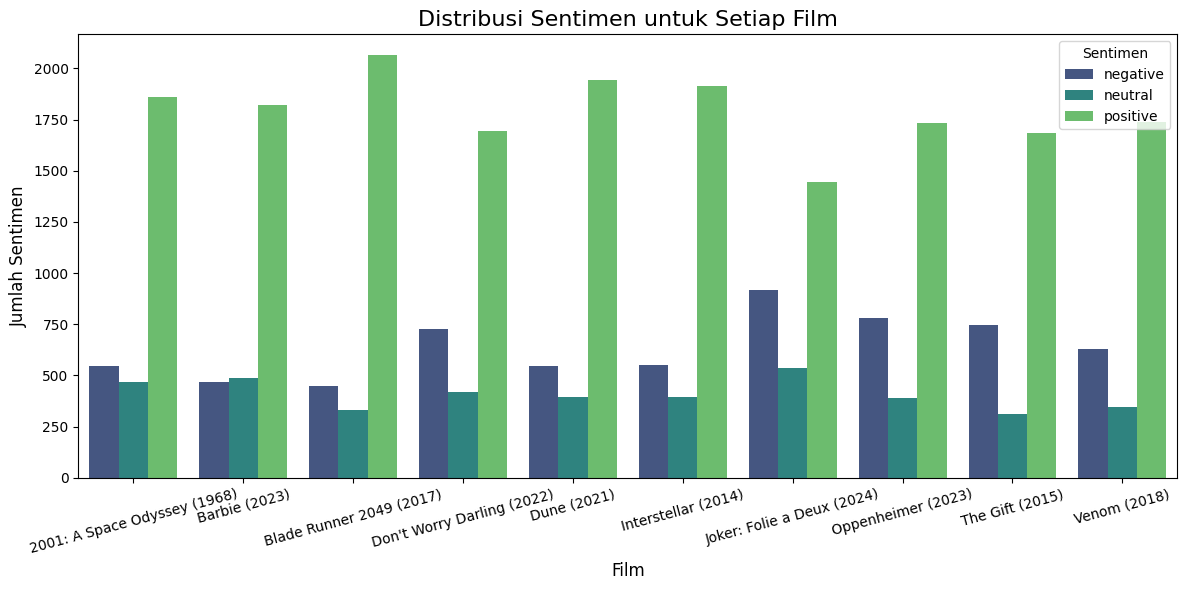

In [183]:
films = ['Dune (2021)', 'Interstellar (2014)', '2001: A Space Odyssey (1968)', 'Blade Runner 2049 (2017)', 'Joker: Folie a Deux (2024)', 'Venom (2018)', "Don't Worry Darling (2022)", 'The Gift (2015)', 'Oppenheimer (2023)', 'Barbie (2023)']
filtered_df = df[df['film'].isin(films)]

sentiment_counts = filtered_df.groupby(['film', 'sentiment_label']).size().reset_index(name='count')

plt.figure(figsize=(12, 6))
sns.barplot(data=sentiment_counts, x='film', y='count', hue='sentiment_label', palette='viridis')

plt.title('Distribusi Sentimen untuk Setiap Film', fontsize=16)
plt.xlabel('Film', fontsize=12)
plt.ylabel('Jumlah Sentimen', fontsize=12)
plt.legend(title='Sentimen', loc='upper right')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

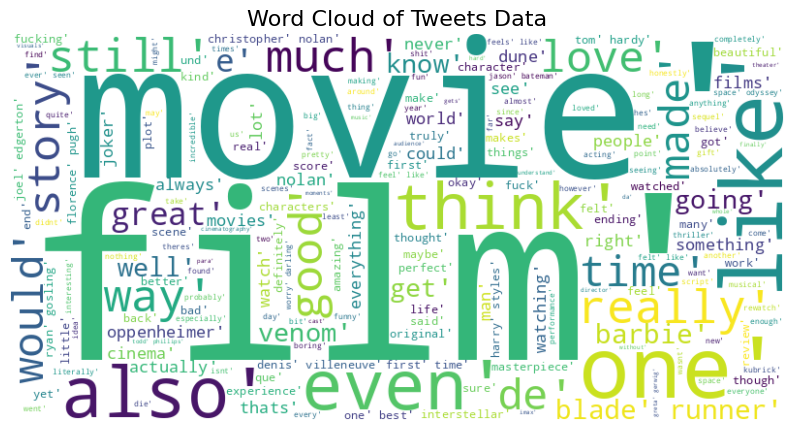

In [184]:
from wordcloud import WordCloud

all_text = ' '.join(df['text_stopword'].astype(str).tolist())

# Visualisasi Word Cloud Kata yang Sering Muncul
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis', contour_color='black').generate(all_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Tweets Data', fontsize=16)
plt.show()

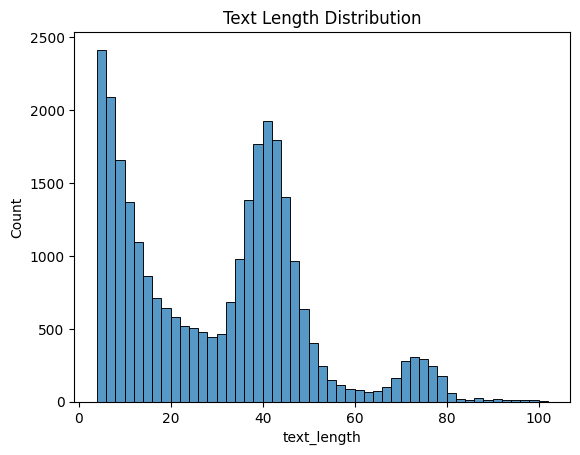

In [185]:
# Visualisasi Distribusi Panjang Teks
df['text_length'] = df['text_akhir'].apply(lambda x: len(x.split()))
sns.histplot(df['text_length'])
plt.title('Text Length Distribution')
plt.show()

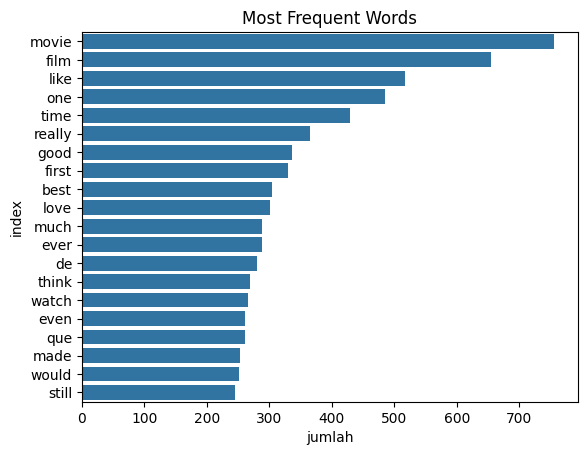

In [186]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Visualisasi Kata Paling Sering Muncul
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['text_akhir'])
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df = tfidf_df.sum().reset_index(name='jumlah')
tfidf_df = tfidf_df.sort_values('jumlah', ascending=False).head(20)
sns.barplot(x='jumlah', y='index', data=tfidf_df)
plt.title('Most Frequent Words')
plt.show()

In [187]:
df.head(2)

,film,username,review,rating,numeric_rating,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir,sentiment_score,sentiment_label,text_length
0,Dune (2021),Jay,how you gonna birth the chosen one with unlimi...,★★★½,7.0,how you gonna birth the chosen one with unlimi...,how you gonna birth the chosen one with unlimi...,how you going to birth the chosen one with unl...,"[how, you, going, to, birth, the, chosen, one,...","[going, birth, chosen, one, unlimited, undisco...",going birth chosen one unlimited undiscovered ...,"{'neg': 0.0, 'neu': 0.921, 'pos': 0.079, 'comp...",positive,15
1,Dune (2021),Karsten,got the 4D experience by forgetting to drink w...,★★★★½,9.0,got the D experience by forgetting to drink wa...,got the d experience by forgetting to drink wa...,got the d experience by forgetting to drink wa...,"[got, the, d, experience, by, forgetting, to, ...","[got, experience, forgetting, drink, water, to...",got experience forgetting drink water today wa...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral,9


## Feature Extraction & Modelling

In [188]:
# Memisahkan teks review dengan label
X = df['text_akhir']
y = df['sentiment_label']

### Feature Extraction

In [189]:
# Ekstraksi fitur dengan TF-IDF
tfidf = TfidfVectorizer(max_features=7000, min_df=10, max_df=0.7, ngram_range=(1,1))
X_tfidf = tfidf.fit_transform(X)

### Modelling with ML Algorithm
using Logistic Regression

In [190]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [191]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score

# Model Logistic Regression
clf = LogisticRegression(max_iter=1000, C=10, solver='saga', multi_class='multinomial')
clf.fit(X_train, y_train)

print("Test Accuracy before using GridSearchCV:", clf.score(X_test, y_test))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Test Accuracy before using GridSearchCV: 0.8390398870455348


In [192]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=1000, solver='saga', multi_class='multinomial'))
])

param_grid = {
    'tfidf__max_features': [3000, 5000, 7000],
    'tfidf__min_df': [5, 10, 15, 17],
    'tfidf__max_df': [0.7, 0.8],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'clf__C': [0.1, 1, 10]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X, y)

print("Best parameters:")
print(grid_search.best_params_)

print("\nBest cross-validation accuracy:")
print(grid_search.best_score_)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_pred = grid_search.best_estimator_.predict(X_test)

print("\nTest Accuracy after using GridSearchCV:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 144 candidates, totalling 432 fits


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Best parameters:
{'clf__C': 10, 'tfidf__max_df': 0.7, 'tfidf__max_features': 7000, 'tfidf__min_df': 15, 'tfidf__ngram_range': (1, 1)}

Best cross-validation accuracy:
0.7945773505008468

Test Accuracy after using GridSearchCV: 0.9428168019767031

Classification Report:
              precision    recall  f1-score   support

    negative       0.92      0.88      0.90      1246
     neutral       0.94      0.91      0.92       821
    positive       0.95      0.97      0.96      3599

    accuracy                           0.94      5666
   macro avg       0.94      0.92      0.93      5666
weighted avg       0.94      0.94      0.94      5666



### Modelling with Deep Learning Algorithm
using LSTM

In [193]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

df['text_joined'] = df['text_tokenizingText'].apply(lambda x: ' '.join(x))

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text_joined'])

sequences = tokenizer.texts_to_sequences(df['text_joined'])
X_padded = pad_sequences(sequences, maxlen=100)
vocab_size = len(tokenizer.word_index) + 1

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
if 'numeric_rating' not in df.columns:
    df['numeric_rating'] = df['rating'].apply(convert_rating)  # Assuming 'convert_rating' function is defined
    df['numeric_rating'] = df['numeric_rating'].fillna(df['numeric_rating'].median())

numeric_feature = scaler.fit_transform(df[['numeric_rating']])

In [194]:
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Dropout, BatchNormalization

# Model Deep Learning LSTM
input_text = Input(shape=(100,))
embedding = Embedding(input_dim=vocab_size, output_dim=100, input_length=100)(input_text)
lstm_out = LSTM(128)(embedding)

input_numeric = Input(shape=(1,))

concat = Concatenate()([lstm_out, input_numeric])

dense = Dense(64, activation='relu')(concat)
output = Dense(3, activation='softmax')(dense)

model = Model(inputs=[input_text, input_numeric], outputs=output)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 100, 100)  │  8,218,600 │ input_layer_8[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 128)       │    117,248 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_9       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 129)       │          0 │ lstm_4[0][0],     │
│ (Concatenate)       │                   │            │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 64)        │      8,320 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 3)         │        195 │ dense_7[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,344,363 (31.83 MB)

 Trainable params: 8,344,363 (31.83 MB)

 Non-trainable params: 0 (0.00 B)

In [195]:
from keras.utils import to_categorical

label_map = {'positive': 0, 'neutral': 1, 'negative': 2}
df['label_encoded'] = df['sentiment_label'].map(label_map)
y = to_categorical(df['label_encoded'])

X_text_train, X_text_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    X_padded, numeric_feature, y, test_size=0.2, random_state=42
)

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.85):
      print("\nAkurasi Validasi telah mencapai >85%!")
      self.model.stop_training = True
callbacks = myCallback()

model.fit([X_text_train, X_num_train], y_train, epochs=5, batch_size=64, validation_data=([X_text_test, X_num_test], y_test), callbacks = [callbacks])

Epoch 1/5
355/355 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.6714 - loss: 0.7701 - val_accuracy: 0.8009 - val_loss: 0.5296
Epoch 2/5
355/355 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8646 - loss: 0.3724 - val_accuracy: 0.8480 - val_loss: 0.4636
Epoch 3/5
355/355 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9386 - loss: 0.2000 - val_accuracy: 0.8080 - val_loss: 0.5782
Epoch 4/5
355/355 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.9620 - loss: 0.1291 - val_accuracy: 0.8330 - val_loss: 0.5909
Epoch 5/5
355/355 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9769 - loss: 0.0806 - val_accuracy: 0.8285 - val_loss: 0.7442


In [196]:
loss, accuracy = model.evaluate([X_text_test, X_num_test], y_test)
print(f"Akurasi Validasi: {accuracy:.2%}")

178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8324 - loss: 0.7267
Akurasi Validasi: 82.85%


### Modelling with Pre-trained Model
using BERT

In [197]:
# Model Pre-trained BERT
X_train, X_test, y_train, y_test = train_test_split(
    df['text_akhir'], df['label_encoded'], test_size=0.2, random_state=42
)

from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def encode_texts(texts, max_len=128):
    return tokenizer(
        texts.tolist(),
        truncation=True,
        padding='max_length',
        max_length=max_len,
        return_tensors='tf'
    )

train_encodings = encode_texts(X_train)
test_encodings = encode_texts(X_test)

In [198]:
import tensorflow as tf

def create_dataset(encodings, labels):
    return tf.data.Dataset.from_tensor_slices((
        dict(encodings),
        labels
    )).batch(16)

train_dataset = create_dataset(train_encodings, y_train)
test_dataset = create_dataset(test_encodings, y_test)

In [199]:
from transformers import TFBertForSequenceClassification, create_optimizer
from tensorflow.keras.optimizers import Adam

# Load model BERT untuk klasifikasi
model = TFBertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=3
)

num_train_steps = len(train_dataset) * 3
optimizer, lr_schedule = create_optimizer(
    init_lr=2e-5,
    num_warmup_steps=0,
    num_train_steps=num_train_steps
)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

history = model.fit(
    train_dataset,
    epochs=3,
    validation_data=test_dataset
)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
1417/1417 [==============================] - 676s 439ms/step - loss: 0.4252 - accuracy: 0.8393 - val_loss: 0.2960 - val_accuracy: 0.8909
Epoch 2/3
1417/1417 [==============================] - 660s 466ms/step - loss: 0.2071 - accuracy: 0.9316 - val_loss: 0.2687 - val_accuracy: 0.9058
Epoch 3/3
1417/1417 [==============================] - 627s 442ms/step - loss: 0.1238 - accuracy: 0.9611 - val_loss: 0.2673 - val_accuracy: 0.9169


In [206]:
results = model.evaluate(test_dataset)
print(f"Akurasi: {results[1]:.2%}")

355/355 [==============================] - 49s 137ms/step - loss: 0.2673 - accuracy: 0.9169
Akurasi: 91.69%


## Prediction

In [207]:
# Prediksi data baru
sample_text = input('Masukkan teks (dalam Bahasa Inggris): ')
inputs = tokenizer(sample_text, return_tensors='tf')
outputs = model(inputs)
predicted_class = tf.argmax(outputs.logits, axis=1).numpy()[0]

print(f"Prediksi: {list(label_map.keys())[predicted_class]}")

Masukkan teks (dalam Bahasa Inggris): So painful watching this, such a terrible movie
Prediksi: negative
